# Exploring Loan Data Patterns
## by Aliscia Boyd

## Investigation Overview

> I will be investigating the relationships between the characteristics of consumer loans and the effect they have on one another. I framed my examination of the data according to two factors:

  > - Whether the consumer is a homeowner or renter
  > - Whether the consumer has a good or bad debt-to-income ratio

## Dataset Overview

> In this project I examine a dataset containing the loan information of customers of San Francisco based US company Prosper Loans. This dataset has 105,383 loans with 81 variables regarding each. I decided to keep 38 of those variables for my analysis. Both loan characteristics (amount, monthly payment, loan status, etc.) as well as relevant consumer information (income range, credit score, employment, etc.) are included within.

In [1]:
# import all packages and set plots to be embedded inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
from textwrap import wrap

%matplotlib inline

# suppress warnings from final output
import warnings
warnings.simplefilter("ignore")

In [2]:
#load in the dataset into a pandas dataframe
loans = pd.read_csv('prosperLoanData.csv')

In [3]:
#Making a copy of the data set to work with
loans_clean = loans.copy()

In [4]:
#Creating a list of needed columns
unneeded_columns = ['ListingKey', 'ListingCategory'
                  'CreditGrade', 'BorrowerAPR', 
                  'BorrowerRate', 'LenderYield', 'EstimatedEffectiveYield', 
                  'EstimatedLoss', 'EstimatedReturn', 'Occupation', 'CurrentlyInGroup', 
                  'GroupKey', 'LoanKey', 'TotalProsperLoans', 'TotalProsperPaymentsBilled', 'OnTimeProsperPayments', 
                  'ProsperPaymentsLessThanOneMonthLate', 'ProsperPaymentsOneMonthPlusLate', 'ProsperPrincipalBorrowed', 'ProsperPrincipalOutstanding', 'ScorexChangeAtTimeOfListing', 
                  'MemberKey', 'PercentFunded', 'Recommendations', 'InvestmentFromFriendsCount', 'InvestmentFromFriendsAmount', 'DateCreditPulled', 'FirstRecordedCreditLine'
                   'CurrentCreditLines','OpenCreditLines','TotalCreditLinespast7Years', 'OpenRevolvingAccounts', 'OpenRevolvingMonthlyPayment', 'InquiriesLast6Months',
                   'TotalInquiries', 'PublicRecordsLast10Years', 'PublicRecordsLast12Months', 'TotalTrades', 'TradesNeverDelinquent', 'TradesOpenedLast6Months', 'LoanFirstDefaultedCycleNumber', 'LoanNumber',
                   'LP_CustomerPayments', 'LP_CustomerPrincipalPayments', 'LP_InterestandFees', 'LP_ServiceFees', 'LP_CollectionFees', 'LP_GrossPrincipalLoss', 'LP_NetPrincipalLoss', 'LP_NonPrincipalRecoverypayments']

#Dropping all columns not in the above list
loans_clean.drop(columns=[col for col in loans_clean if col in unneeded_columns], inplace=True)

In [5]:
#Confirming column drop
loans_clean.dtypes

ListingNumber                           int64
ListingCreationDate                    object
CreditGrade                            object
Term                                    int64
LoanStatus                             object
ClosedDate                             object
ProsperRating (numeric)               float64
ProsperRating (Alpha)                  object
ProsperScore                          float64
ListingCategory (numeric)               int64
BorrowerState                          object
EmploymentStatus                       object
EmploymentStatusDuration              float64
IsBorrowerHomeowner                      bool
CreditScoreRangeLower                 float64
CreditScoreRangeUpper                 float64
FirstRecordedCreditLine                object
CurrentCreditLines                    float64
TotalCreditLinespast7years            float64
CurrentDelinquencies                  float64
AmountDelinquent                      float64
DelinquenciesLast7Years           

In [6]:
#Set all column names to lowercase
loans_clean.columns = loans_clean.columns.str.lower()

#Remove spaces and parentheses in column names
loans_clean.columns = loans_clean.columns.str.replace('(', ' ')
loans_clean.columns = loans_clean.columns.str.replace(')', ' ')
loans_clean.columns = loans_clean.columns.str.replace(' ', '')

#Use a for loop to change certain numerical columns  
#to string/object datatype
for col in ['listingnumber', 'term']:
    loans_clean[col] = loans_clean[col].astype(str)

#Use a for loop to change certain string/object columns  
#to datetime datatype
for col in ['listingcreationdate', 'closeddate', 'firstrecordedcreditline', 'loanoriginationdate']:
    loans_clean[col] = pd.to_datetime(loans_clean[col], infer_datetime_format=True)

In [7]:
#Isolating and dropping the rows with  null values in the debttoincomeratio
#field, which will be the primary focus of my analysis
loans_clean = loans_clean[loans_clean['debttoincomeratio'].notnull()]

In [8]:
#Confirming changes in cell above
loans_clean.dtypes

listingnumber                              object
listingcreationdate                datetime64[ns]
creditgrade                                object
term                                       object
loanstatus                                 object
closeddate                         datetime64[ns]
prosperratingnumeric                      float64
prosperratingalpha                         object
prosperscore                              float64
listingcategorynumeric                      int64
borrowerstate                              object
employmentstatus                           object
employmentstatusduration                  float64
isborrowerhomeowner                          bool
creditscorerangelower                     float64
creditscorerangeupper                     float64
firstrecordedcreditline            datetime64[ns]
currentcreditlines                        float64
totalcreditlinespast7years                float64
currentdelinquencies                      float64


In [9]:
#Creating a function to define the values of the
#acceptabledebtratio column
def ratiocalc(loans_clean):
        
    if (loans_clean['isborrowerhomeowner'] == True) and (loans_clean['debttoincomeratio'] < .36):
        loans_clean['acceptabledebtratio'] = True
    
    elif (loans_clean['isborrowerhomeowner'] == False) and (loans_clean['debttoincomeratio'] < .20):
        loans_clean['acceptabledebtratio'] = True
    
    else:
        loans_clean['acceptabledebtratio'] = False
    
    return loans_clean['acceptabledebtratio']

#Creating the acceptabledebtratio column and applying the above function to it
loans_clean['acceptabledebtratio'] = loans_clean.apply(ratiocalc, axis=1)

In [10]:
#Confirming the change to the dataset
loans_clean['acceptabledebtratio'].value_counts()

True     67580
False    37803
Name: acceptabledebtratio, dtype: int64

In [11]:
#Mask for homeowners with a good debt ratio
goodhomerows = loans_clean.loc[((loans_clean['isborrowerhomeowner'] == True) & (loans_clean['acceptabledebtratio'] == True))]

#Mask for homeowners with a bad debt ratio
badhomerows = loans_clean.loc[((loans_clean['isborrowerhomeowner'] == True) & (loans_clean['acceptabledebtratio'] == False))]

#Mask for renters with a good debt ratio
goodrentrows = loans_clean.loc[((loans_clean['isborrowerhomeowner'] == False) & (loans_clean['acceptabledebtratio'] == True))]

#Mask for renters with a bad debt ratio
badrentrows = loans_clean.loc[((loans_clean['isborrowerhomeowner'] == False) & (loans_clean['acceptabledebtratio'] == False))]

### According to page 2 of <a href="https://files.consumerfinance.gov/f/documents/cfpb_your-money-your-goals_debt_income_calc_tool_2018-11_ADA.pdf">this</a> document from the US Consumer Financial Protection Bureau, consumers should have a debt ratio no higher than 36% if they own a home, and no higher than 20% if they rent. 

###  I created a new column in the dataset that states whether a consumer's ratio is acceptable or not according to the CFPB's guidelines. I then used this column alongside the column that determines home ownership to create four masks for the loan data:

> - A mask for home owners with a good debt ratio
> - A mask for home owners with a bad debt ratio
> - A mask for renters with a good debt ratio
> - A mask for renters with a bad debt ratio

### I then examined the data through these four masks to compare and contrast the results. Below I present a few of my visualizations and provide a brief interpretation and explanation for each.

## Visualization 1 - Debt Ratio Distributions

> I began by comparing the distribution of loan statuses for each of the four groups. I found that homeowners with good ratios are the group with the most current loans. This is not surprising as homeowners would likely have 15 or 30 year mortgages.

> I did find it very interesting that renters with good ratios have the most completed loans, but also the most defaults and chargeoffs!

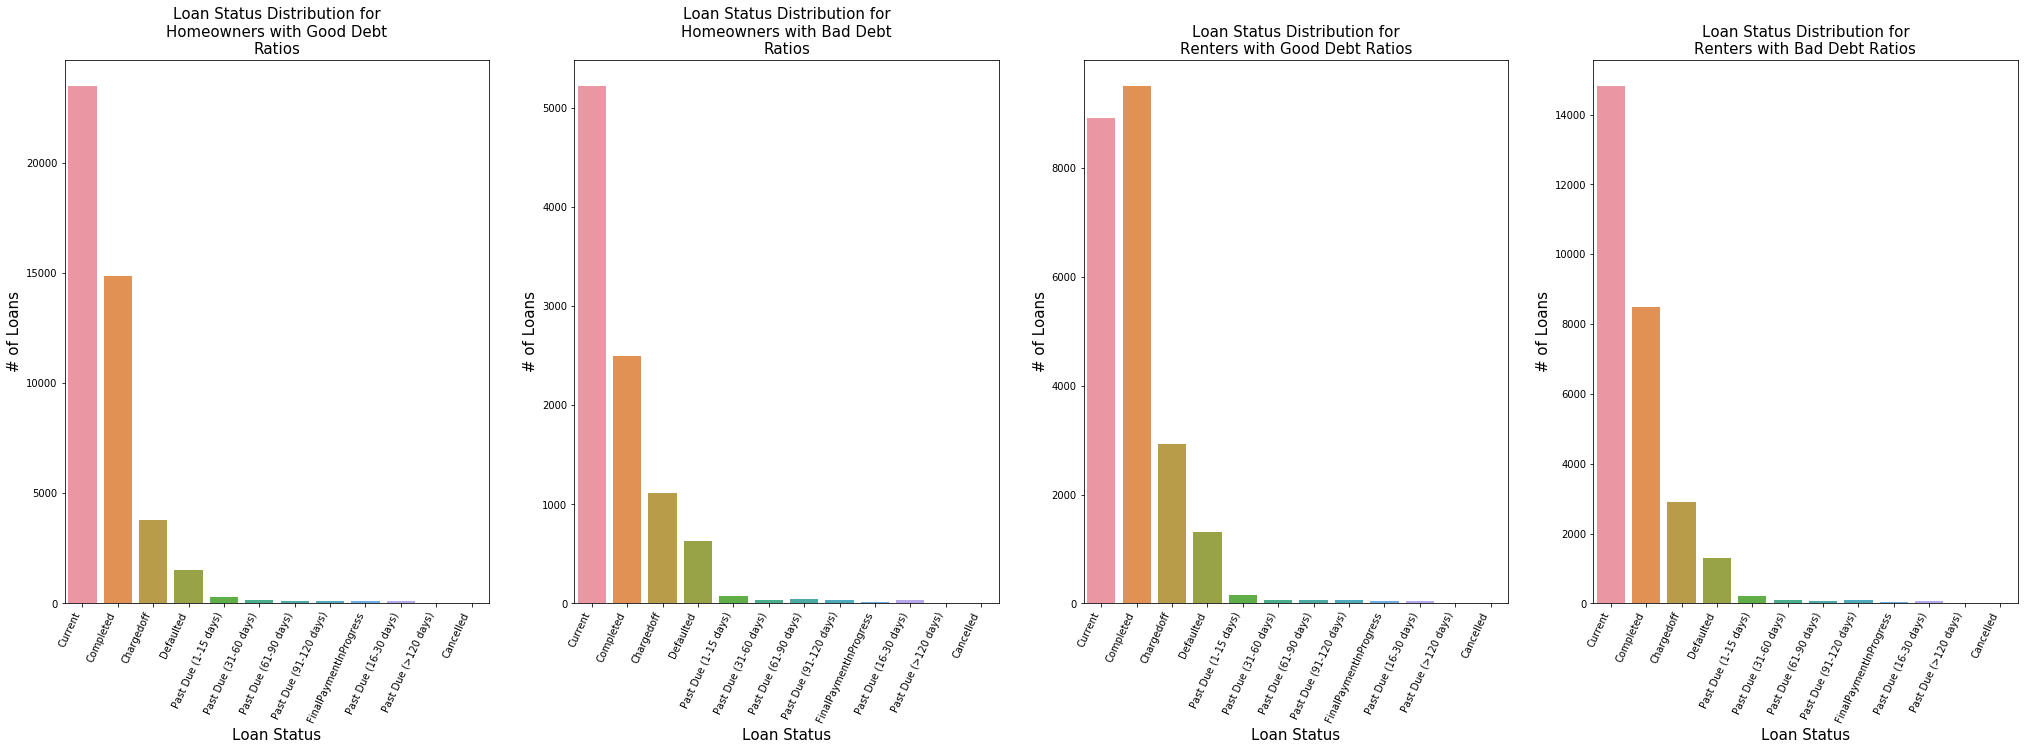

In [12]:
#Displaying the values of the loanstatus column for each group

#Setting the values to be plotted for each chart
goodh=goodhomerows['loanstatus'].value_counts()
badh=badhomerows['loanstatus'].value_counts()
goodr=goodrentrows['loanstatus'].value_counts()
badr=badrentrows['loanstatus'].value_counts()

#Setting the order that the variable values will be plotted in
plot_order = goodh.index

#Creating the barcharts for each category of consumers
f, axes = plt.subplots(1,4,figsize=(35,10))
goodhchart=sb.countplot(data=goodhomerows, x='loanstatus', order=plot_order, ax=axes[0]);
badhchart=sb.countplot(data=badhomerows, x='loanstatus', order=plot_order, ax=axes[1]);
goodrchart=sb.countplot(data=goodrentrows, x='loanstatus', order=plot_order, ax=axes[2]);
badrchart=sb.countplot(data=badrentrows, x='loanstatus', order=plot_order, ax=axes[3]);

#Customizing the labels for the x-axis on each chart
goodhchart.set_xticklabels(goodhchart.get_xticklabels(),rotation=65, horizontalalignment='right')
badhchart.set_xticklabels(badhchart.get_xticklabels(),rotation=65, horizontalalignment='right')
goodrchart.set_xticklabels(goodrchart.get_xticklabels(),rotation=65, horizontalalignment='right')
badrchart.set_xticklabels(badrchart.get_xticklabels(),rotation=65, horizontalalignment='right')

#Setting the chart titles
goodhchart.set_title("\n".join(wrap("Loan Status Distribution for Homeowners with Good Debt Ratios", 30)), fontsize=15)
badhchart.set_title("\n".join(wrap("Loan Status Distribution for Homeowners with Bad Debt Ratios", 30)), fontsize=15)
goodrchart.set_title("\n".join(wrap("Loan Status Distribution for Renters with Good Debt Ratios", 30)), fontsize=15)
badrchart.set_title("\n".join(wrap("Loan Status Distribution for Renters with Bad Debt Ratios", 30)), fontsize=15)

goodhchart.set_xlabel('Loan Status', fontsize=15)
goodhchart.set_ylabel('# of Loans', fontsize=15)
badhchart.set_xlabel('Loan Status', fontsize=15)
badhchart.set_ylabel('# of Loans', fontsize=15)
goodrchart.set_xlabel('Loan Status', fontsize=15)
goodrchart.set_ylabel('# of Loans', fontsize=15)
badrchart.set_xlabel('Loan Status', fontsize=15)
badrchart.set_ylabel('# of Loans', fontsize=15)

#Displaying the charts
f.show()

In [13]:
#Calculating percentage of consumers that are current on their loans in each group
goodhcurrentpercent=((goodhomerows['loanstatus'] == 'Current').sum()/(len(goodhomerows['loanstatus'])))
badhcurrentpercent=((badhomerows['loanstatus'] == 'Current').sum()/(len(badhomerows['loanstatus'])))
goodrcurrentpercent=((goodrentrows['loanstatus'] == 'Current').sum()/(len(goodrentrows['loanstatus'])))
badrcurrentpercent=((badrentrows['loanstatus'] == 'Current').sum()/(len(badrentrows['loanstatus'])))

#Displaying the calculated percentages
print ("Percentage of current loans for Homeowners with a Good Debt Ratio:\n", goodhcurrentpercent)
print ("\nPercentage of current loans for Homeowners with a Bad Debt Ratio:\n", badhcurrentpercent)
print ("\nPercentage of current loans for Renters with a Good Debt Ratio:\n", goodrcurrentpercent)
print ("\nPercentage of current loans for Renters with a Bad Debt Ratio:\n", badrcurrentpercent)

Percentage of current loans for Homeowners with a Good Debt Ratio:
 0.528352369817

Percentage of current loans for Homeowners with a Bad Debt Ratio:
 0.538604267601

Percentage of current loans for Renters with a Good Debt Ratio:
 0.386296745152

Percentage of current loans for Renters with a Bad Debt Ratio:
 0.527684862287


In [14]:
#Calculating percentage of consumers that are defaulted on their loans in each group
goodhdefaultedpercent=((goodhomerows['loanstatus'] == 'Defaulted').sum()/(len(goodhomerows['loanstatus'])))
badhdefaultedpercent=((badhomerows['loanstatus'] == 'Defaulted').sum()/(len(badhomerows['loanstatus'])))
goodrdefaultedpercent=((goodrentrows['loanstatus'] == 'Defaulted').sum()/(len(goodrentrows['loanstatus'])))
badrdefaultedpercent=((badrentrows['loanstatus'] == 'Defaulted').sum()/(len(badrentrows['loanstatus'])))

#Displaying the calculated percentages
print ("Percentage of defaulted loans for Homeowners with a Good Debt Ratio:\n",goodhdefaultedpercent)
print ("\nPercentage of defaulted loans for Homeowners with a Bad Debt Ratio:\n",badhdefaultedpercent)
print ("\nPercentage of defaulted loans for Renters with a Good Debt Ratio:\n",goodrdefaultedpercent)
print ("\nPercentage of defaulted loans for Renters with a Bad Debt Ratio:\n",badrdefaultedpercent)

Percentage of defaulted loans for Homeowners with a Good Debt Ratio:
 0.034445543664

Percentage of defaulted loans for Homeowners with a Bad Debt Ratio:
 0.0651479228945

Percentage of defaulted loans for Renters with a Good Debt Ratio:
 0.0563971606648

Percentage of defaulted loans for Renters with a Bad Debt Ratio:
 0.0461177140417


In [15]:
#Calculating percentage of consumers that charged off their loans in each group
goodhchargedoffpercent=((goodhomerows['loanstatus'] == 'Chargedoff').sum()/(len(goodhomerows['loanstatus'])))
badhchargedoffpercent=((badhomerows['loanstatus'] == 'Chargedoff').sum()/(len(badhomerows['loanstatus'])))
goodrchargedoffpercent=((goodrentrows['loanstatus'] == 'Chargedoff').sum()/(len(goodrentrows['loanstatus'])))
badrchargedoffpercent=((badrentrows['loanstatus'] == 'Chargedoff').sum()/(len(badrentrows['loanstatus'])))

#Displaying the calculated percentages
print ("Percentage of charged off loans for Homeowners with a Good Debt Ratio:\n",goodhchargedoffpercent)
print ("\nPercentage of charged off loans for Homeowners with a Bad Debt Ratio:\n",badhchargedoffpercent)
print ("\nPercentage of charged off loans for Renters with a Good Debt Ratio:\n",goodrchargedoffpercent)
print ("\nPercentage of charged off loans for Renters with a Bad Debt Ratio:\n",badrchargedoffpercent)

Percentage of charged off loans for Homeowners with a Good Debt Ratio:
 0.085102077525

Percentage of charged off loans for Homeowners with a Bad Debt Ratio:
 0.115142768787

Percentage of charged off loans for Renters with a Good Debt Ratio:
 0.127034279778

Percentage of charged off loans for Renters with a Bad Debt Ratio:
 0.103693687282


## Visualization 2 - Investors vs. Prosper Rating

> Another aspect of the data that I explored is the relationship between the number of investors and Prosper's numerical rating for each loan consumer within each group.

> For each debt ratio group, the number of investors per loan did generally increase for each iteration of Propser rating. Most loans across all debt ratio groups and scores had around 100 or fewer investors. I was surprised to find that loans of larger amounts typically had less investors than smaller loans overall.

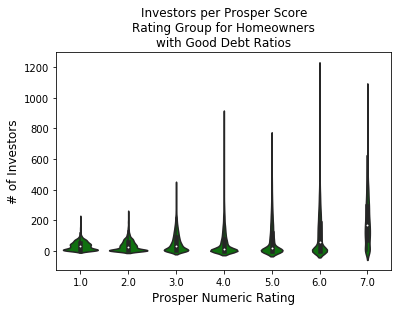

In [27]:
sb.violinplot(data=goodhomerows, x='prosperratingnumeric', y='investors', color='green', innner=None)
plt.title("\n".join(wrap('Investors per Prosper Score Rating Group for Homeowners with Good Debt Ratios', 30)))
plt.xlabel('Prosper Numeric Rating', fontsize=12)
plt.ylabel('# of Investors', fontsize=12);

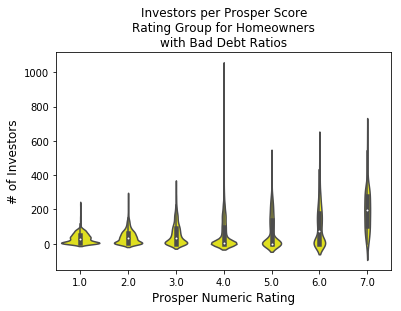

In [28]:
sb.violinplot(data=badhomerows, x='prosperratingnumeric', y='investors', color='yellow', innner=None)
plt.title("\n".join(wrap('Investors per Prosper Score Rating Group for Homeowners with Bad Debt Ratios', 30)))
plt.xlabel('Prosper Numeric Rating', fontsize=12)
plt.ylabel('# of Investors', fontsize=12);

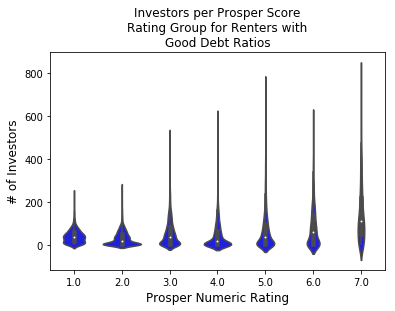

In [29]:
sb.violinplot(data=goodrentrows, x='prosperratingnumeric', y='investors', color='blue', innner=None)
plt.title("\n".join(wrap('Investors per Prosper Score Rating Group for Renters with Good Debt Ratios', 30)))
plt.xlabel('Prosper Numeric Rating', fontsize=12)
plt.ylabel('# of Investors', fontsize=12);

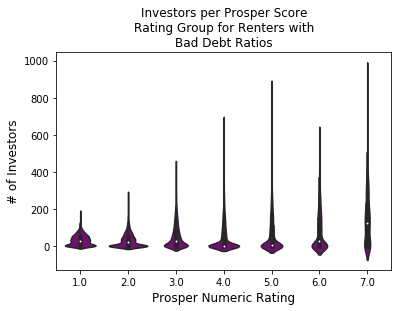

In [30]:
sb.violinplot(data=badrentrows, x='prosperratingnumeric', y='investors', color='purple', innner=None)
plt.title("\n".join(wrap('Investors per Prosper Score Rating Group for Renters with Bad Debt Ratios', 30)))
plt.xlabel('Prosper Numeric Rating', fontsize=12)
plt.ylabel('# of Investors', fontsize=12);

## Visualization 3 - Credit Score and Loan Amount Relationships

> Lastly, I analyzed the relationship between credit score and original loan amounts, and how that relationship changed as a consumers Prosper Score changed. For all groups, a credit score of around 750 or higher seems to be the point where a noticeable rise in Propser score is seen. Loan amounts also seem to correlate positively with both Prosper score and upper credit range. So consumers with higher Prosper scores and upper credit limits are seemingly approved for bigger loans.

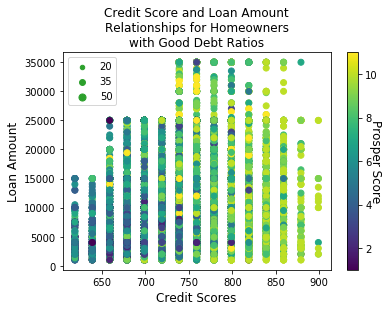

In [31]:
plt.scatter(data = goodhomerows, x = 'creditscorerangeupper', y = 'loanoriginalamount', c = 'prosperscore')
plt.colorbar().set_label('Prosper Score', fontsize=12, rotation=270)
plt.title("\n".join(wrap('Credit Score and Loan Amount Relationships for Homeowners with Good Debt Ratios', 30)))

sizes = [20, 35, 50]
base_color = sb.color_palette()[2]
legend_obj = []
for s in sizes:
    legend_obj.append(plt.scatter([], [], s = s, color = base_color))
plt.legend(legend_obj, sizes)
plt.xlabel('Credit Scores', fontsize=12)
plt.ylabel('Loan Amount', fontsize=12);

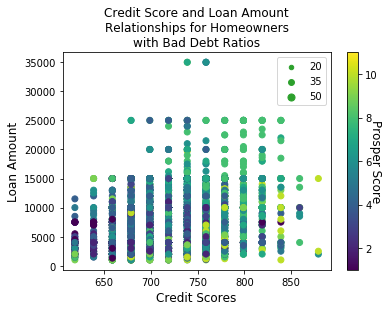

In [32]:
plt.scatter(data = badhomerows, x = 'creditscorerangeupper', y = 'loanoriginalamount', c = 'prosperscore')
plt.colorbar().set_label('Prosper Score', fontsize=12, rotation=270)
plt.title("\n".join(wrap('Credit Score and Loan Amount Relationships for Homeowners with Bad Debt Ratios', 30)))

sizes = [20, 35, 50]
base_color = sb.color_palette()[2]
legend_obj = []
for s in sizes:
    legend_obj.append(plt.scatter([], [], s = s, color = base_color))
plt.legend(legend_obj, sizes)
plt.xlabel('Credit Scores', fontsize=12)
plt.ylabel('Loan Amount', fontsize=12);

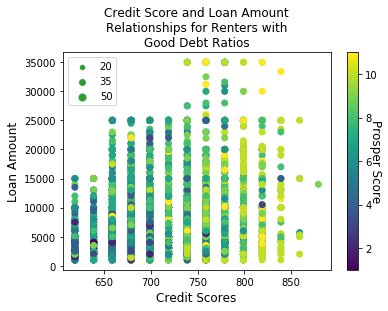

In [33]:
plt.scatter(data = goodrentrows, x = 'creditscorerangeupper', y = 'loanoriginalamount', c = 'prosperscore')
plt.colorbar().set_label('Prosper Score', fontsize=12, rotation=270)
plt.title("\n".join(wrap('Credit Score and Loan Amount Relationships for Renters with Good Debt Ratios', 30)))

sizes = [20, 35, 50]
base_color = sb.color_palette()[2]
legend_obj = []
for s in sizes:
    legend_obj.append(plt.scatter([], [], s = s, color = base_color))
plt.legend(legend_obj, sizes)
plt.xlabel('Credit Scores', fontsize=12)
plt.ylabel('Loan Amount', fontsize=12);

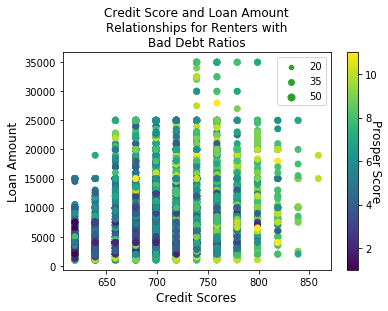

In [34]:
plt.scatter(data = badrentrows, x = 'creditscorerangeupper', y = 'loanoriginalamount', c = 'prosperscore')
plt.colorbar().set_label('Prosper Score', fontsize=12, rotation=270)
plt.title("\n".join(wrap('Credit Score and Loan Amount Relationships for Renters with Bad Debt Ratios', 30)))

sizes = [20, 35, 50]
base_color = sb.color_palette()[2]
legend_obj = []
for s in sizes:
    legend_obj.append(plt.scatter([], [], s = s, color = base_color))
plt.legend(legend_obj, sizes)
plt.xlabel('Credit Scores', fontsize=12)
plt.ylabel('Loan Amount', fontsize=12);